# DeepFM Recommender System - Expedia Hotel dataset

## Import Libraries

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import warnings
import math
import sys
import holidays
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from math import sqrt


from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense

from deepctr.inputs import build_input_features, get_linear_logit, input_from_feature_columns, combined_dnn_input
from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.utils import add_func
from deepctr.models import DeepFM


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr.inputs import SparseFeat,get_feature_names



In [2]:
df = pd.read_csv('../data/hotel_data/train.csv', sep=',', nrows=100000)
df.shape

(100000, 24)

## Data Preprocessing

In [3]:
df.head(n=2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1


In [4]:
# rename 2 columns
df = df.rename(columns={'hotel_cluster': 'item_id', 'is_booking': 'rating'})

In [5]:
#Define an information dectionary for features
info_dic = {'date_time':'Timestamp',
'site_name':'ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, …)',
'posa_continent':'ID of continent associated with site_name',
'user_location_country':'The ID of the country the customer is located',
'user_location_region':'The ID of the region the customer is located',
'user_location_city':'The ID of the city the customer is located',
'orig_destination_distance':'Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated',
'user_id':'ID of user','is_mobile':'1 when a user connected from a mobile device, 0 otherwise',
'is_package':'1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise',
'channel':'ID of a marketing channel',
'srch_ci':'Checkin date','srch_co':'Checkout date',
'srch_adults_cnt':'The number of adults specified in the hotel room',
'srch_children_cnt':'The number of (extra occupancy) children specified in the hotel room',
'srch_rm_cnt':'The number of hotel rooms specified in the search',
'srch_destination_id':'ID of the destination where the hotel search was performed',
'srch_destination_type_id':'Type of destination',
'hotel_continent':'Hotel continent',
'hotel_country':'Hotel country',
'hotel_market':'Hotel market','rating':'(is_booking)1 if a booking, 0 if a click',
'cnt':'Numer of similar events in the context of the same user session','item_id':'(hotel_cluster)ID of a hotel cluster'}

In [6]:
len(df['user_location_country'].unique())

123

In [7]:
info_dic['srch_ci'],info_dic['srch_co']

('Checkin date', 'Checkout date')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
date_time                    100000 non-null object
site_name                    100000 non-null int64
posa_continent               100000 non-null int64
user_location_country        100000 non-null int64
user_location_region         100000 non-null int64
user_location_city           100000 non-null int64
orig_destination_distance    63078 non-null float64
user_id                      100000 non-null int64
is_mobile                    100000 non-null int64
is_package                   100000 non-null int64
channel                      100000 non-null int64
srch_ci                      99929 non-null object
srch_co                      99929 non-null object
srch_adults_cnt              100000 non-null int64
srch_children_cnt            100000 non-null int64
srch_rm_cnt                  100000 non-null int64
srch_destination_id          100000 non-null int64
srch_destination_type

## Feature Engineering

In [9]:
df= df.drop(['orig_destination_distance'],axis=1)
df = df.dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99929 entries, 0 to 99999
Data columns (total 23 columns):
date_time                   99929 non-null object
site_name                   99929 non-null int64
posa_continent              99929 non-null int64
user_location_country       99929 non-null int64
user_location_region        99929 non-null int64
user_location_city          99929 non-null int64
user_id                     99929 non-null int64
is_mobile                   99929 non-null int64
is_package                  99929 non-null int64
channel                     99929 non-null int64
srch_ci                     99929 non-null object
srch_co                     99929 non-null object
srch_adults_cnt             99929 non-null int64
srch_children_cnt           99929 non-null int64
srch_rm_cnt                 99929 non-null int64
srch_destination_id         99929 non-null int64
srch_destination_type_id    99929 non-null int64
rating                      99929 non-null int64
cnt   

In [13]:
# Define holidays in some countries
ca_holidays = holidays.Canada()
us_holidays = holidays.UnitedStates()

uk_holidays = holidays.UnitedKingdom()
gr_holidays = holidays.Germany()

In [14]:
# check if checkin or checkout date is in holiday of different countries
df['north_am_ci'] = df['srch_ci'].apply(lambda x: 1 if x in (us_holidays or ca_holidays)  else 0)
df['north_am_co'] = df['srch_co'].apply(lambda x: 1 if x in (us_holidays or ca_holidays)  else 0)

df['europe_ci'] = df['srch_ci'].apply(lambda x: 1 if x in (uk_holidays or gr_holidays)  else 0)
df['europe_co'] = df['srch_co'].apply(lambda x: 1 if x in (uk_holidays or gr_holidays)  else 0)

In [15]:
df.head(n=2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,...,hotel_country,hotel_market,item_id,click_month,checkin_month,checkout_month,north_am_ci,north_am_co,europe_ci,europe_co
0,2014-08-11 07:46:59,2,3,66,348,48862,12,0,1,9,...,50,628,1,8,8,8,0,0,0,0
1,2014-08-11 08:22:12,2,3,66,348,48862,12,0,1,9,...,50,628,1,8,8,9,0,0,0,0


In [16]:
# extract month from date_time
df['click_month'] = pd.DatetimeIndex(df['date_time']).month
df['checkin_month'] = pd.DatetimeIndex(df['srch_ci']).month
df['checkout_month'] = pd.DatetimeIndex(df['srch_co']).month

In [17]:
df= df.drop(['date_time'],axis=1)
df= df.drop(['srch_ci'],axis=1)
df= df.drop(['srch_co'],axis=1)

In [18]:
df.shape

(99929, 27)

In [19]:
df.columns

Index(['site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city', 'user_id', 'is_mobile',
       'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'rating', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'item_id', 'click_month', 'checkin_month', 'checkout_month',
       'north_am_ci', 'north_am_co', 'europe_ci', 'europe_co'],
      dtype='object')

In [20]:
#Remove rows with the same user_id and item_id and different rating

#max_rating = df.groupby(['user_id', 'item_id']).rating.transform(max)
#df = df.loc[df.rating == max_rating]
#df.drop_duplicates(keep='first',inplace=True)

In [22]:
# categ_sparse / conti_dense
sparse_features = ['site_name','posa_continent','user_location_country','user_location_region','user_location_city',
             'user_id','is_mobile','is_package','channel','click_month','checkin_month','checkout_month',
            'srch_adults_cnt','srch_children_cnt','srch_rm_cnt','srch_destination_id','hotel_continent',
               'hotel_country','cnt','north_am_ci', 'north_am_co', 'europe_ci', 'europe_co','click_month',
                   'checkin_month','checkout_month']

dense_features = ['hotel_market']
target = ['rating']

### Simple preprocessing

In [23]:
# Label Encoding for sparse features,and normalization for dense numerical features
for feat in sparse_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

In [24]:
mms = MinMaxScaler(feature_range=(0,1))
df[dense_features] = mms.fit_transform(df[dense_features])

### Generate feature columns
For sparse features, we transform them into dense vectors by embedding techniques. For dense numerical features, we concatenate them to the input tensors of fully connected layer.

In [25]:
# count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, df[feat].nunique(),embedding_dim=4)
                          for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

### Generate the training samples and train the model

In [26]:
# generate input data for model
train, test = train_test_split(df, test_size=0.2)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

# Model Before Hyper-Parameter Tuning

In [32]:
model = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary')
model.compile("adam", "binary_crossentropy",metrics=['binary_crossentropy'])

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
pred_ans = model.predict(test_model_input, batch_size=256)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 63954 samples, validate on 15989 samples
Epoch 1/10
63954/63954 - 4s - loss: 0.2826 - binary_crossentropy: 0.2824 - val_loss: 0.2456 - val_binary_crossentropy: 0.2451
Epoch 2/10
63954/63954 - 2s - loss: 0.2241 - binary_crossentropy: 0.2232 - val_loss: 0.2527 - val_binary_crossentropy: 0.2515
Epoch 3/10
63954/63954 - 2s - loss: 0.2091 - binary_crossentropy: 0.2077 - val_loss: 0.2685 - val_binary_crossentropy: 0.2667
Epoch 4/10
63954/63954 - 3s - loss: 0.2001 - binary_crossentropy: 0.1981 - val_loss: 0.2883 - val_binary_crossentropy: 0.2861
Epoch 5/10
63954/63954 - 3s - loss: 0.1945 - binary_crossentropy: 0.1921 - val_loss: 0.2957 - val_binary_crossentropy: 0.2930
Epoch 6/10
63954/63954 - 2s - loss: 0.1901 - binary_crossentropy: 0.1873 - val_loss: 0.3061 - val_binary_crossentropy: 0.3032
Epoch 7/10
63954/63954 - 2s - loss: 0.1864 - binary_crossentropy: 0.1834 - val_loss: 0.3201 - val_bi

In [33]:
auc = roc_auc_score(test[target].values, pred_ans)

print("RMSE:\t%f" % np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
      "MAE:\t%f" % np.round(mean_absolute_error(test[target].values, pred_ans),3),
      "MSE:\t%f" % np.round(mean_squared_error(test[target].values, pred_ans),3),
      "AUC:\t%f" % np.round(auc,3),
      sep='\n')

RMSE:	0.285000
MAE:	0.131000
MSE:	0.081000
AUC:	0.707000


# Random Search
This is just a random search and the result might be more acuurate using methods like grid shearch.

In [65]:
param_rand = {'dnn_hidden_units' : [(1,1),(2,2),(4,4),(8,8),(29,29),(128,128),(256,256)],
              'dnn_use_bn':[True,False],
              'l2_reg_linear':[1e-5,1e-3,1e-1,1,10],
              'l2_reg_embedding':[1e-7,1e-5,1e-3,1e-1,1],
              'l2_reg_dnn':[0,0.2,2,4],
              'dnn_dropout':[0, 0.3, 0.5, 0.7, 0.9]
             }
result = {}

### dnn_hidden_units: list,list of positive integer or empty list, the layer number and units in each layer of DNN

In [43]:
dnn_hidden_units_dict = {}
for i in param_rand['dnn_hidden_units']:
    model = DeepFM(linear_feature_columns,dnn_feature_columns,fm_group=['default_group'], dnn_hidden_units=i, 
             init_std=0.0001, seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)
    dnn_hidden_units_dict[i]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_ans),3),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_ans),3),
      "AUC" : np.round(auc,3)}
result['dnn_hidden_units']=dnn_hidden_units_dict

Train on 63954 samples, validate on 15989 samples
Epoch 1/10
63954/63954 - 10s - loss: 0.0971 - mean_squared_error: 0.0970 - val_loss: 0.0751 - val_mean_squared_error: 0.0749
Epoch 2/10
63954/63954 - 4s - loss: 0.0717 - mean_squared_error: 0.0712 - val_loss: 0.0723 - val_mean_squared_error: 0.0716
Epoch 3/10
63954/63954 - 3s - loss: 0.0683 - mean_squared_error: 0.0673 - val_loss: 0.0723 - val_mean_squared_error: 0.0712
Epoch 4/10
63954/63954 - 3s - loss: 0.0664 - mean_squared_error: 0.0650 - val_loss: 0.0730 - val_mean_squared_error: 0.0715
Epoch 5/10
63954/63954 - 3s - loss: 0.0651 - mean_squared_error: 0.0634 - val_loss: 0.0735 - val_mean_squared_error: 0.0716
Epoch 6/10
63954/63954 - 3s - loss: 0.0641 - mean_squared_error: 0.0621 - val_loss: 0.0745 - val_mean_squared_error: 0.0724
Epoch 7/10
63954/63954 - 3s - loss: 0.0632 - mean_squared_error: 0.0609 - val_loss: 0.0756 - val_mean_squared_error: 0.0733
Epoch 8/10
63954/63954 - 3s - loss: 0.0625 - mean_squared_error: 0.0600 - val_los

Epoch 5/10
63954/63954 - 4s - loss: 0.0592 - mean_squared_error: 0.0581 - val_loss: 0.0780 - val_mean_squared_error: 0.0769
Epoch 6/10
63954/63954 - 4s - loss: 0.0580 - mean_squared_error: 0.0569 - val_loss: 0.0784 - val_mean_squared_error: 0.0772
Epoch 7/10
63954/63954 - 6s - loss: 0.0570 - mean_squared_error: 0.0557 - val_loss: 0.0804 - val_mean_squared_error: 0.0791
Epoch 8/10
63954/63954 - 5s - loss: 0.0560 - mean_squared_error: 0.0547 - val_loss: 0.0829 - val_mean_squared_error: 0.0815
Epoch 9/10
63954/63954 - 4s - loss: 0.0551 - mean_squared_error: 0.0537 - val_loss: 0.0840 - val_mean_squared_error: 0.0825
Epoch 10/10
63954/63954 - 4s - loss: 0.0544 - mean_squared_error: 0.0530 - val_loss: 0.0850 - val_mean_squared_error: 0.0835


In [44]:
dnn_hidden_units_dict

{(1, 1): {'RMSE': 0.272, 'MAE': 0.149, 'MSE': 0.074, 'AUC': 0.765},
 (2, 2): {'RMSE': 0.279, 'MAE': 0.132, 'MSE': 0.078, 'AUC': 0.754},
 (4, 4): {'RMSE': 0.281, 'MAE': 0.133, 'MSE': 0.079, 'AUC': 0.751},
 (8, 8): {'RMSE': 0.281, 'MAE': 0.129, 'MSE': 0.079, 'AUC': 0.749},
 (29, 29): {'RMSE': 0.282, 'MAE': 0.131, 'MSE': 0.079, 'AUC': 0.751},
 (128, 128): {'RMSE': 0.286, 'MAE': 0.126, 'MSE': 0.082, 'AUC': 0.752},
 (256, 256): {'RMSE': 0.285, 'MAE': 0.123, 'MSE': 0.081, 'AUC': 0.749}}

In [47]:
dnn_hidden_units_dict[(128, 128)]

{'RMSE': 0.286, 'MAE': 0.126, 'MSE': 0.082, 'AUC': 0.752}

### dnn_use_bn – bool. Whether use BatchNormalization before activation or not in DNN

In [51]:
dnn_use_bn_dict = {}
for i in param_rand['dnn_use_bn']:
    model= DeepFM(linear_feature_columns,dnn_feature_columns,fm_group=['default_group'],dnn_hidden_units=(128,128), 
             init_std=0.0001, seed=1024,task='binary',dnn_use_bn=i)

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)
    dnn_use_bn_dict[i]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_ans),3),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_ans),3),
      "AUC" : np.round(auc,3)}
result['dnn_use_bn_dict']=dnn_use_bn_dict

Train on 63954 samples, validate on 15989 samples
Epoch 1/10
63954/63954 - 12s - loss: 0.0753 - mean_squared_error: 0.0753 - val_loss: 0.0787 - val_mean_squared_error: 0.0786
Epoch 2/10
63954/63954 - 4s - loss: 0.0675 - mean_squared_error: 0.0673 - val_loss: 0.0726 - val_mean_squared_error: 0.0724
Epoch 3/10
63954/63954 - 4s - loss: 0.0632 - mean_squared_error: 0.0629 - val_loss: 0.0750 - val_mean_squared_error: 0.0747
Epoch 4/10
63954/63954 - 4s - loss: 0.0600 - mean_squared_error: 0.0597 - val_loss: 0.0792 - val_mean_squared_error: 0.0787
Epoch 5/10
63954/63954 - 4s - loss: 0.0571 - mean_squared_error: 0.0566 - val_loss: 0.0826 - val_mean_squared_error: 0.0821
Epoch 6/10
63954/63954 - 4s - loss: 0.0551 - mean_squared_error: 0.0545 - val_loss: 0.0864 - val_mean_squared_error: 0.0857
Epoch 7/10
63954/63954 - 4s - loss: 0.0533 - mean_squared_error: 0.0526 - val_loss: 0.0889 - val_mean_squared_error: 0.0882
Epoch 8/10
63954/63954 - 4s - loss: 0.0517 - mean_squared_error: 0.0509 - val_los

In [52]:
dnn_use_bn_dict

{True: {'RMSE': 0.303, 'MAE': 0.149, 'MSE': 0.092, 'AUC': 0.722},
 False: {'RMSE': 0.285, 'MAE': 0.135, 'MSE': 0.081, 'AUC': 0.748}}

In [64]:
dnn_use_bn_dict[False]

{'RMSE': 0.285, 'MAE': 0.135, 'MSE': 0.081, 'AUC': 0.748}

### l2_reg_linear: float. L2 regularizer strength applied to wide part

In [53]:
l2_reg_linear_dict={}
for i in param_rand['l2_reg_linear']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128,128), l2_reg_linear=i,
            fm_group=['default_group'],l2_reg_embedding=1e-5, l2_reg_dnn=0, init_std=0.0001,dnn_use_bn=False,
                   seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)
    
    l2_reg_linear_dict[i]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_ans),3),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_ans),3),
      "AUC" : np.round(auc,3)}
    
result['l2_reg_linear']=l2_reg_linear_dict

Train on 63954 samples, validate on 15989 samples
Epoch 1/10
63954/63954 - 13s - loss: 0.0816 - mean_squared_error: 0.0815 - val_loss: 0.0705 - val_mean_squared_error: 0.0702
Epoch 2/10
63954/63954 - 6s - loss: 0.0665 - mean_squared_error: 0.0660 - val_loss: 0.0720 - val_mean_squared_error: 0.0713
Epoch 3/10
63954/63954 - 5s - loss: 0.0630 - mean_squared_error: 0.0622 - val_loss: 0.0744 - val_mean_squared_error: 0.0735
Epoch 4/10
63954/63954 - 5s - loss: 0.0609 - mean_squared_error: 0.0599 - val_loss: 0.0760 - val_mean_squared_error: 0.0749
Epoch 5/10
63954/63954 - 5s - loss: 0.0594 - mean_squared_error: 0.0583 - val_loss: 0.0785 - val_mean_squared_error: 0.0774
Epoch 6/10
63954/63954 - 5s - loss: 0.0582 - mean_squared_error: 0.0569 - val_loss: 0.0790 - val_mean_squared_error: 0.0777
Epoch 7/10
63954/63954 - 6s - loss: 0.0574 - mean_squared_error: 0.0561 - val_loss: 0.0810 - val_mean_squared_error: 0.0796
Epoch 8/10
63954/63954 - 6s - loss: 0.0567 - mean_squared_error: 0.0553 - val_los

In [54]:
l2_reg_linear_dict

{1e-05: {'RMSE': 0.283, 'MAE': 0.127, 'MSE': 0.08, 'AUC': 0.752},
 0.001: {'RMSE': 0.282, 'MAE': 0.138, 'MSE': 0.08, 'AUC': 0.751},
 0.1: {'RMSE': 0.284, 'MAE': 0.126, 'MSE': 0.08, 'AUC': 0.752},
 1: {'RMSE': 0.282, 'MAE': 0.132, 'MSE': 0.08, 'AUC': 0.75},
 10: {'RMSE': 0.285, 'MAE': 0.127, 'MSE': 0.081, 'AUC': 0.753}}

In [56]:
l2_reg_linear_dict[1e-05]

{'RMSE': 0.283, 'MAE': 0.127, 'MSE': 0.08, 'AUC': 0.752}

### l2_reg_embedding: float. L2 regularizer strength applied to embedding vector

In [58]:
l2_reg_embedding_dict={}
for i in param_rand['l2_reg_embedding']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128,128), l2_reg_linear=1e-05,
            l2_reg_embedding=i, l2_reg_dnn=0, init_std=0.0001, seed=1024, task='binary',
               dnn_use_bn=False,fm_group=['default_group'])

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)
    l2_reg_embedding_dict[i]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_ans),3),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_ans),3),
      "AUC" : np.round(auc,3)}
result['l2_reg_embedding']=l2_reg_embedding_dict

Train on 63954 samples, validate on 15989 samples
Epoch 1/10
63954/63954 - 17s - loss: 0.0816 - mean_squared_error: 0.0816 - val_loss: 0.0699 - val_mean_squared_error: 0.0699
Epoch 2/10
63954/63954 - 5s - loss: 0.0656 - mean_squared_error: 0.0655 - val_loss: 0.0713 - val_mean_squared_error: 0.0713
Epoch 3/10
63954/63954 - 5s - loss: 0.0617 - mean_squared_error: 0.0616 - val_loss: 0.0737 - val_mean_squared_error: 0.0736
Epoch 4/10
63954/63954 - 5s - loss: 0.0593 - mean_squared_error: 0.0592 - val_loss: 0.0764 - val_mean_squared_error: 0.0763
Epoch 5/10
63954/63954 - 4s - loss: 0.0576 - mean_squared_error: 0.0575 - val_loss: 0.0783 - val_mean_squared_error: 0.0782
Epoch 6/10
63954/63954 - 5s - loss: 0.0563 - mean_squared_error: 0.0562 - val_loss: 0.0794 - val_mean_squared_error: 0.0793
Epoch 7/10
63954/63954 - 4s - loss: 0.0550 - mean_squared_error: 0.0549 - val_loss: 0.0797 - val_mean_squared_error: 0.0795
Epoch 8/10
63954/63954 - 5s - loss: 0.0541 - mean_squared_error: 0.0540 - val_los

In [59]:
l2_reg_embedding_dict

{1e-07: {'RMSE': 0.287, 'MAE': 0.132, 'MSE': 0.082, 'AUC': 0.737},
 1e-05: {'RMSE': 0.289, 'MAE': 0.134, 'MSE': 0.084, 'AUC': 0.748},
 0.001: {'RMSE': 0.263, 'MAE': 0.129, 'MSE': 0.069, 'AUC': 0.773},
 0.1: {'RMSE': 0.262, 'MAE': 0.148, 'MSE': 0.069, 'AUC': 0.774},
 1: {'RMSE': 0.262, 'MAE': 0.147, 'MSE': 0.069, 'AUC': 0.775}}

In [61]:
l2_reg_embedding_dict[0.001]

{'RMSE': 0.263, 'MAE': 0.129, 'MSE': 0.069, 'AUC': 0.773}

## l2_reg_dnn: float. L2 regularizer strength applied to DNN

In [62]:
l2_reg_dnn_dict={}
for i in param_rand['l2_reg_dnn']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128, 128), l2_reg_linear=1e-05,
            l2_reg_embedding=0.001, l2_reg_dnn=i, init_std=0.0001, seed=1024,task='binary',
                  dnn_use_bn=False,fm_group=['default_group'])

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)
    
    l2_reg_dnn_dict[i]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_ans),3),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_ans),3),
      "AUC" : np.round(auc,3)}
result['l2_reg_dnn']=l2_reg_dnn_dict

Train on 63954 samples, validate on 15989 samples
Epoch 1/10
63954/63954 - 18s - loss: 0.0824 - mean_squared_error: 0.0812 - val_loss: 0.0732 - val_mean_squared_error: 0.0706
Epoch 2/10
63954/63954 - 5s - loss: 0.0721 - mean_squared_error: 0.0692 - val_loss: 0.0727 - val_mean_squared_error: 0.0703
Epoch 3/10
63954/63954 - 5s - loss: 0.0710 - mean_squared_error: 0.0680 - val_loss: 0.0733 - val_mean_squared_error: 0.0705
Epoch 4/10
63954/63954 - 5s - loss: 0.0701 - mean_squared_error: 0.0670 - val_loss: 0.0732 - val_mean_squared_error: 0.0702
Epoch 5/10
63954/63954 - 5s - loss: 0.0696 - mean_squared_error: 0.0663 - val_loss: 0.0737 - val_mean_squared_error: 0.0706
Epoch 6/10
63954/63954 - 5s - loss: 0.0692 - mean_squared_error: 0.0658 - val_loss: 0.0736 - val_mean_squared_error: 0.0704
Epoch 7/10
63954/63954 - 5s - loss: 0.0688 - mean_squared_error: 0.0652 - val_loss: 0.0745 - val_mean_squared_error: 0.0710
Epoch 8/10
63954/63954 - 5s - loss: 0.0682 - mean_squared_error: 0.0646 - val_los

In [63]:
l2_reg_dnn_dict

{0: {'RMSE': 0.265, 'MAE': 0.145, 'MSE': 0.07, 'AUC': 0.775},
 0.2: {'RMSE': 0.262, 'MAE': 0.147, 'MSE': 0.069, 'AUC': 0.77},
 2: {'RMSE': 0.263, 'MAE': 0.159, 'MSE': 0.069, 'AUC': 0.769},
 4: {'RMSE': 0.262, 'MAE': 0.151, 'MSE': 0.069, 'AUC': 0.77}}

In [53]:
l2_reg_dnn_dict[0]

{'RMSE': 0.267, 'MAE': 0.14, 'MSE': 0.071, 'AUC': 0.778}

### dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
#### dnn_activation: Activation function to use in DNN

In [66]:
dnn_dropout_dict={}
for i in param_rand['dnn_dropout']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128,128)
                , init_std=0.0001, seed=1024, dnn_dropout=i, dnn_activation='relu',task='binary',
                   fm_group=['default_group'],dnn_use_bn=False)

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)
    
    dnn_dropout_dict[i]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_ans),3),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_ans),3),
      "AUC" : np.round(auc,3)}
result['dnn_dropout']=dnn_dropout_dict

Train on 63954 samples, validate on 15989 samples
Epoch 1/10
63954/63954 - 21s - loss: 0.0811 - mean_squared_error: 0.0810 - val_loss: 0.0701 - val_mean_squared_error: 0.0698
Epoch 2/10
63954/63954 - 5s - loss: 0.0665 - mean_squared_error: 0.0660 - val_loss: 0.0714 - val_mean_squared_error: 0.0707
Epoch 3/10
63954/63954 - 5s - loss: 0.0631 - mean_squared_error: 0.0623 - val_loss: 0.0750 - val_mean_squared_error: 0.0741
Epoch 4/10
63954/63954 - 5s - loss: 0.0609 - mean_squared_error: 0.0600 - val_loss: 0.0760 - val_mean_squared_error: 0.0750
Epoch 5/10
63954/63954 - 5s - loss: 0.0595 - mean_squared_error: 0.0584 - val_loss: 0.0784 - val_mean_squared_error: 0.0772
Epoch 6/10
63954/63954 - 5s - loss: 0.0582 - mean_squared_error: 0.0570 - val_loss: 0.0796 - val_mean_squared_error: 0.0783
Epoch 7/10
63954/63954 - 5s - loss: 0.0574 - mean_squared_error: 0.0561 - val_loss: 0.0808 - val_mean_squared_error: 0.0794
Epoch 8/10
63954/63954 - 6s - loss: 0.0566 - mean_squared_error: 0.0552 - val_los

In [67]:
dnn_dropout_dict

{0: {'RMSE': 0.286, 'MAE': 0.124, 'MSE': 0.082, 'AUC': 0.752},
 0.3: {'RMSE': 0.289, 'MAE': 0.122, 'MSE': 0.083, 'AUC': 0.748},
 0.5: {'RMSE': 0.281, 'MAE': 0.117, 'MSE': 0.079, 'AUC': 0.747},
 0.7: {'RMSE': 0.284, 'MAE': 0.125, 'MSE': 0.08, 'AUC': 0.741},
 0.9: {'RMSE': 0.278, 'MAE': 0.119, 'MSE': 0.077, 'AUC': 0.745}}

In [68]:
#***
dnn_dropout_dict[ 0.9]

{'RMSE': 0.278, 'MAE': 0.119, 'MSE': 0.077, 'AUC': 0.745}

# Best Model after hyper-parameter tuning

In [70]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128,128)
            , init_std=0.0001, seed=1024, dnn_dropout=0.9, dnn_activation='relu',task='binary',
               fm_group=['default_group'],dnn_use_bn=False)

model.compile("adam", "mse", metrics=['mse'])

In [71]:
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Train on 63954 samples, validate on 15989 samples
Epoch 1/10
63954/63954 - 27s - loss: 0.0886 - mean_squared_error: 0.0886 - val_loss: 0.0736 - val_mean_squared_error: 0.0735
Epoch 2/10
63954/63954 - 6s - loss: 0.0723 - mean_squared_error: 0.0721 - val_loss: 0.0712 - val_mean_squared_error: 0.0709
Epoch 3/10
63954/63954 - 7s - loss: 0.0681 - mean_squared_error: 0.0676 - val_loss: 0.0721 - val_mean_squared_error: 0.0714
Epoch 4/10
63954/63954 - 7s - loss: 0.0653 - mean_squared_error: 0.0645 - val_loss: 0.0739 - val_mean_squared_error: 0.0729
Epoch 5/10
63954/63954 - 7s - loss: 0.0634 - mean_squared_error: 0.0624 - val_loss: 0.0759 - val_mean_squared_error: 0.0747
Epoch 6/10
63954/63954 - 6s - loss: 0.0623 - mean_squared_error: 0.0611 - val_loss: 0.0776 - val_mean_squared_error: 0.0763
Epoch 7/10
63954/63954 - 5s - loss: 0.0609 - mean_squared_error: 0.0596 - val_loss: 0.0786 - val_mean_squared_error: 0.0772
Epoch 8/10
63954/63954 - 6s - loss: 0.0602 - mean_squared_error: 0.0588 - val_los

In [72]:
pred_ans = model.predict(test_model_input, batch_size=256)

auc = roc_auc_score(test[target].values, pred_ans)

In [73]:
print("RMSE:\t%f" % np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
      "MAE:\t%f" % np.round(mean_absolute_error(test[target].values, pred_ans),3),
      "MSE:\t%f" % np.round(mean_squared_error(test[target].values, pred_ans),3),
      "AUC:\t%f" % np.round(auc,3),
      sep='\n')

RMSE:	0.279000
MAE:	0.117000
MSE:	0.078000
AUC:	0.748000


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(test[target].values, pred_ans, pos_label=2)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.748


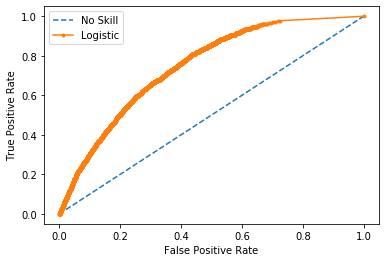

In [81]:
# roc curve and auc

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(pred_ans))]
# predict probabilities
lr_probs = pred_ans

# calculate scores
ns_auc = roc_auc_score(test[target].values, ns_probs)
lr_auc = roc_auc_score(test[target].values, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test[target].values, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test[target].values, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Resources:

https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html

https://deepctr-doc.readthedocs.io/en/latest/Examples.html

https://github.com/shenweichen/DeepCTR/blob/ce140ffcc1057e8fb57622ae1732c39df32bc11e/docs/source/FAQ.md

https://github.com/shenweichen/DeepCTR/blob/db229dc31f0d4c79c0de2ece0bb919b35258d6b2/tests/models/DeepFM_test.py

https://github.com/shenweichen/DeepCTR/blob/db229dc31f0d4c79c0de2ece0bb919b35258d6b2/examples/run_regression_movielens.py
